In [ ]:
!pip install -q 'aif360[all]' dataframe-image lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import dataframe_image as dfi

# Datasets
from aif360.datasets import StandardDataset

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

# seaborn
import seaborn as sns

np.random.seed(1)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [ ]:
import pandas as pd
#load data
df = pd.read_csv('/content/Student Mental health.csv')
df.head()

,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)

In [ ]:
df.drop(columns=['Timestamp'], inplace=True)

In [ ]:
# turn the dataset into an AIF360 dataset
def get_favourable1(stress_level):
    return stress_level==0

#dataset = aif360.datasets.StandardDataset(
#    your_pandas_df,
#    label_name,
#    favorable_classes,
#    protected_attribute_names,
#    privileged_classes)

DW = StandardDataset(
    df,
    "Do you have Depression?",
    get_favourable1,
    ["Choose your gender"],
    [[0]])

In [ ]:
(dataset_train,
 dataset_val,
 dataset_test) = DW.split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_train.privileged_protected_attributes[sens_ind]]

In [ ]:
# explore the disparate impact
metric_train = BinaryLabelDatasetMetric(
        dataset_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_train = MetricTextExplainer(metric_train)

print(explainer_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.1384615384615386


In [ ]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        print('aif360 inprocessing algorithm')
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)


        # calculate the F1 score

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['F1_score'].append(metric.true_positive_rate() /
                                      (metric.true_positive_rate() + (0.5 *(metric.false_positive_rate() + metric.false_negative_rate()))))

        metric_arrs['FP Diff'].append(metric.false_positive_rate_difference())

        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        #metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs

In [ ]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name, filename=None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 1)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 1)
    else:
        ax2.set_ylim(-0.25, 1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    if filename:
        fig.savefig(filename)
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("F1 score: {:6.4f}".format(metrics['F1_score'][best_ind]))
    print("FP Diff: {:6.4f}".format(metrics['FP Diff'][best_ind]))
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print('Corresponding disparate impact value: {:6.4f}'.format(metrics['disp_imp'][best_ind]))
    #print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [ ]:
dataset = dataset_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_dataset = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [ ]:
thresh_arr = np.linspace(0.1, 0.9, 50)
val_metrics = test(dataset=dataset_val,
                   model=lr_dataset,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

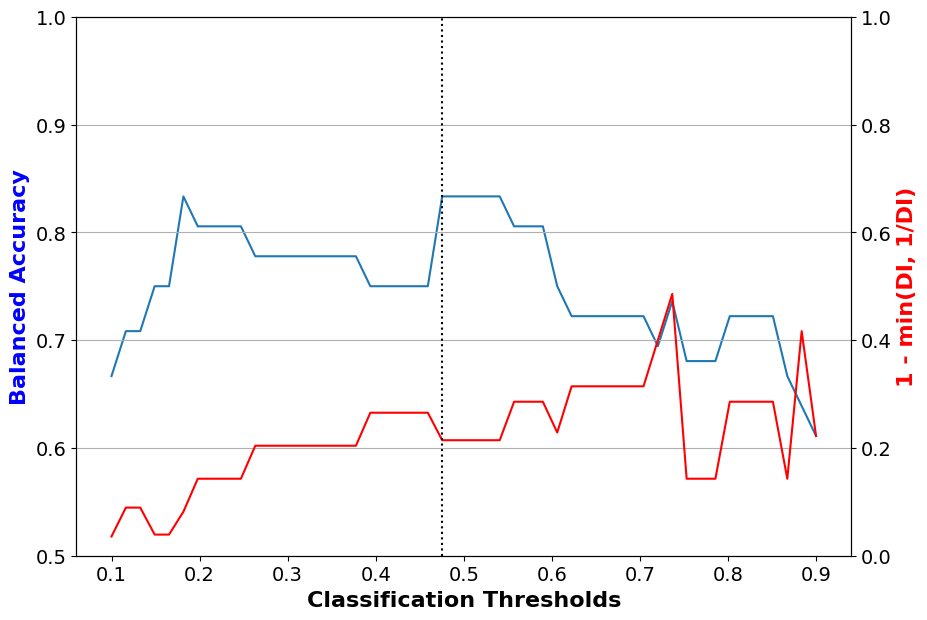

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)',
    filename='LR_DI_none.eps')

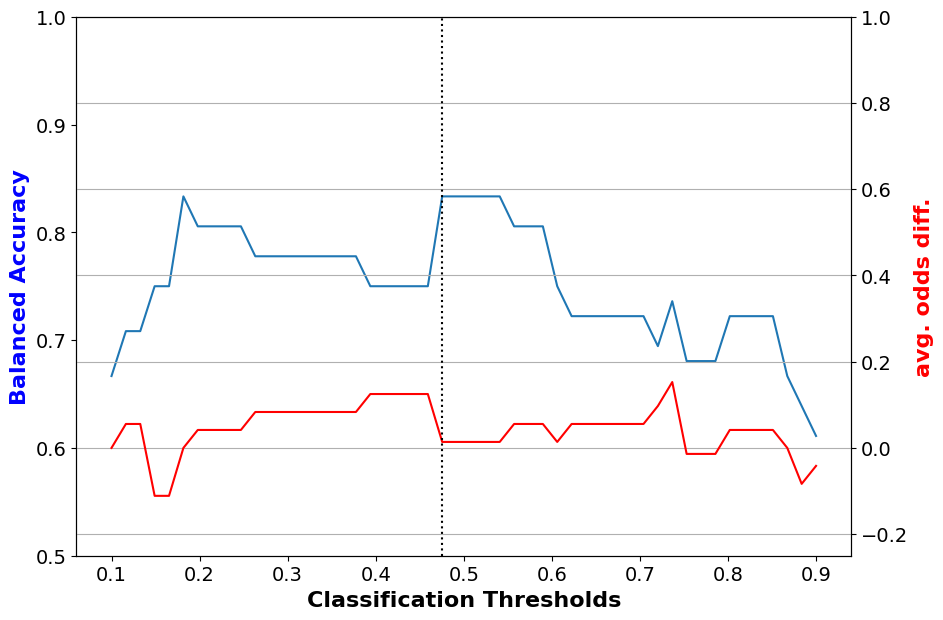

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.',
    filename='LR_AOD_none.eps')

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.4755
Best balanced accuracy: 0.8333
F1 score: 0.8333
FP Diff: -0.2222
Corresponding 1-min(DI, 1/DI) value: 0.2143
Corresponding average odds difference value: 0.0139
Corresponding statistical parity difference value: 0.1429
Corresponding equal opportunity difference value: 0.2500
Corresponding disparate impact value: 1.2727


In [ ]:
# inprocess mitigation - prejudice remover
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_DW = model.fit(dataset)

In [ ]:
thresh_arr = np.linspace(0.01, 0.8, 50)

dataset = dataset_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_DW,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

aif360 inprocessing algorithm


Threshold corresponding to Best balanced accuracy: 0.2518
Best balanced accuracy: 0.7083
F1 score: 0.7407
FP Diff: 0.3333
Corresponding 1-min(DI, 1/DI) value: 0.3571
Corresponding average odds difference value: 0.2917
Corresponding statistical parity difference value: 0.3175
Corresponding equal opportunity difference value: 0.2500
Corresponding disparate impact value: 1.5556


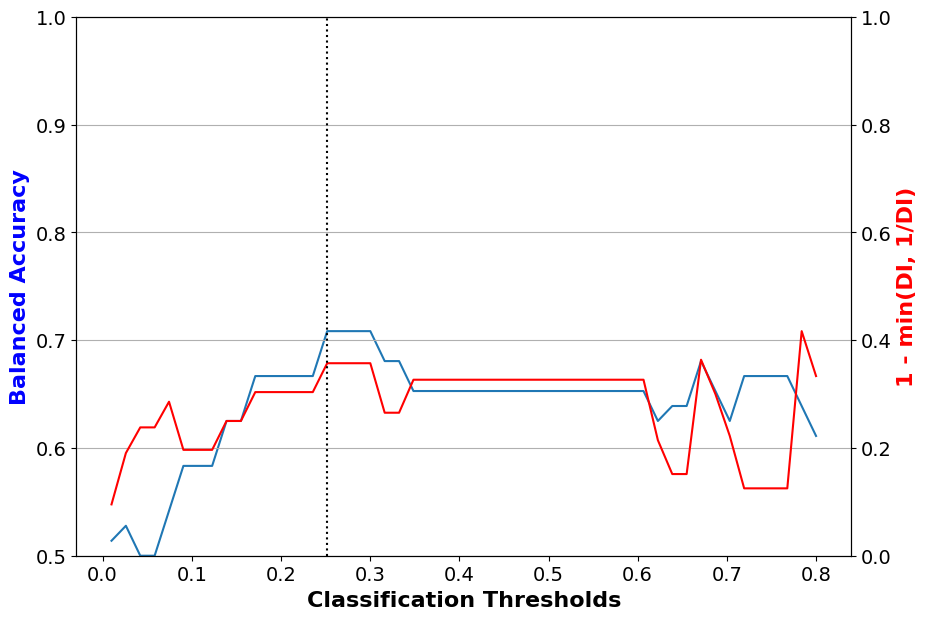

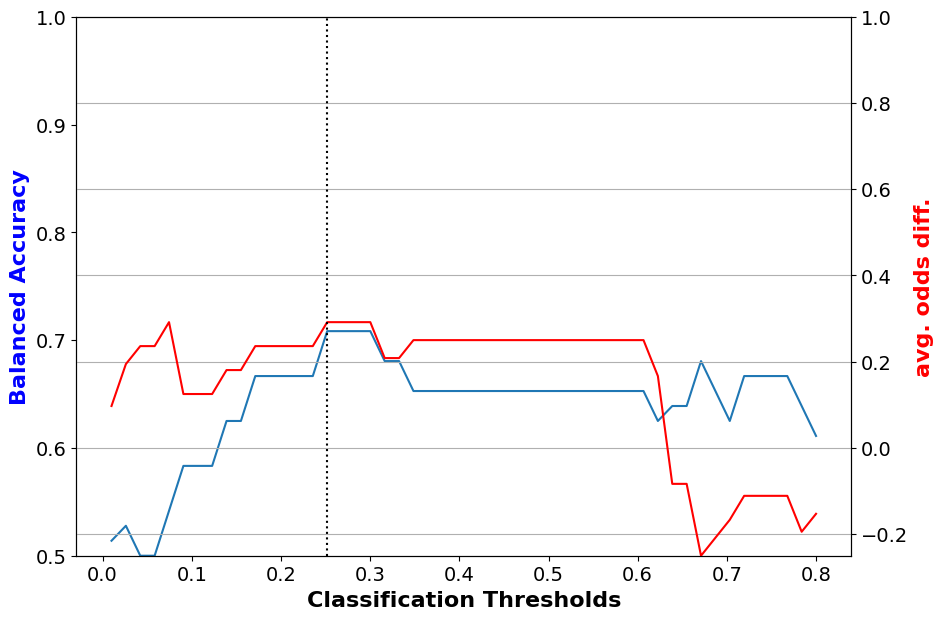

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)',
    filename='LR_DI_PR.eps')
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.',
    filename='LR_AOD_PR.eps')
describe_metrics(val_metrics, thresh_arr)